## Importing

In [1]:
!pip install textattack

In [2]:
import textattack
from textattack.constraints.semantics.sentence_encoders import UniversalSentenceEncoder
import transformers
from textattack.attack_results.successful_attack_result import SuccessfulAttackResult
from textattack.shared.word_embeddings import WordEmbedding
import numpy as np
import json
from numpy import dot
from numpy.linalg import norm
import pandas as pd
from IPython.core.display import display, HTML
from textattack.loggers import CSVLogger
import torch
from textattack.models.helpers.lstm_for_classification import LSTMForClassification
from textattack.models.wrappers.pytorch_model_wrapper import PyTorchModelWrapper
from textattack.datasets import HuggingFaceDataset
from sklearn.metrics import accuracy_score

## Helper Functions

In [31]:
def load_model_and_tokenizer(hugging_face_path):
    model = transformers.AutoModelForSequenceClassification.from_pretrained(hugging_face_path)
    tokenizer = transformers.AutoTokenizer.from_pretrained(hugging_face_path)
    model_wrapper = textattack.models.wrappers.HuggingFaceModelWrapper(model, tokenizer)
    return model_wrapper


def get_use_embeddings(use, adv_attacks_results):
    original_texts = []
    adversarial_texts = []
    for result in adv_attacks_results:
        if isinstance(result, SuccessfulAttackResult):
            original_texts.append(result.original_text())
            adversarial_texts.append(result.perturbed_text())

    use_original_embeddings = use.encode(original_texts)
    use_adv_embeddings = use.encode(adversarial_texts)
    return use_original_embeddings, use_adv_embeddings


def get_avg_cosine_sim(original_embeddings, adv_embeddings):
    # Compute avg. cosine similarity between the embeddings computed using the Universal Sentence Encoding
    cos_sim = []
    sim_metric = torch.nn.CosineSimilarity(dim=1)
    cosine_similarities = sim_metric(torch.tensor(original_embeddings),
                                     torch.tensor(adv_embeddings))
    return np.mean(cosine_similarities.numpy())



def get_cosine_sim(original_embeddings, adv_embeddings):
    cos_sim = []
    sim_metric = torch.nn.CosineSimilarity(dim=1)
    cosine_similarities = sim_metric(torch.tensor(original_embeddings),
                                     torch.tensor(adv_embeddings))
    return cosine_similarities.numpy().tolist()


def get_words_embedding_distances(embedding, original_text,
                                  adv_text):
    word_distances = []
    for word, adv_word in zip(original_text, adv_text):
        if word != adv_word:
            # print(word, adv_word)
            try:
              cos_sim = embedding.get_cos_sim(word, adv_word)
            except KeyError:
              continue
            word_distances.append( (word, adv_word, cos_sim) )

    return word_distances


def get_min_words_distance(embedding, adv_attacks_results):
    succesful_attacks = list(filter(lambda res: isinstance(res, SuccessfulAttackResult),
                          adv_attacks_results))

    min_distances = []
    for res in succesful_attacks:
        original_text = res.original_result.attacked_text.words
        adversarial_text = res.perturbed_result.attacked_text.words

        embedding_distances = get_words_embedding_distances(embedding,
                                                            original_text,
                                                            adversarial_text)
        # Get the words with minimum embedding cosine similarity
        if len(embedding_distances) == 0:
            continue
        min_words_distance_i = min(embedding_distances, key = lambda x: x[2])
        min_distances.append(min_words_distance_i)
    return min_distances

def display_results(attacks_results, output_file):
    pd.options.display.max_colwidth = (
    480  # increase colum width so we can actually read the examples
    )

    logger = CSVLogger(color_method="html")

    for result in attacks_results:
        if isinstance(result, SuccessfulAttackResult):
            logger.log_attack_result(result)

    results = pd.DataFrame.from_records(logger.row_list)

    if not results.empty:
        html_content = results[["original_text", "perturbed_text"]].to_html(escape=False)

        with open(output_file, 'w') as file:
            file.write(html_content)


def transfer_attack(model_wrapper, attack_results):

    succesful_attacks = list(filter(lambda res: isinstance(res, SuccessfulAttackResult),
                          attack_results))

    original_text = [res.original_text() for res in succesful_attacks]
    adversarial_text = [res.perturbed_text() for res in succesful_attacks]
    original_labels = [res.original_result.ground_truth_output for res in succesful_attacks]
    original_model_predicted_labels = np.argmax(model_wrapper(original_text), axis=1)
    adv_model_pred_labels = np.argmax(model_wrapper(adversarial_text), axis=1)

    original_accuracy = accuracy_score(original_labels,
                                       original_model_predicted_labels)
    adv_accuracy = accuracy_score(original_labels, adv_model_pred_labels)
    return original_accuracy, adv_accuracy


def create_use_data(original_embeddings, adversarial_embeddings, cosine_sim):
    use_data_dic = {}
    use_data_dic['original_embeddings'] = original_embeddings
    use_data_dic['adversarial_embeddings'] = adversarial_embeddings
    use_data_dic['cosine_sim'] = cosine_sim
    return use_data_dic

def dictToJSON(data, filename = "data.json"):
  with open(filename, 'w') as f:
    json.dump(data, f)



class FixedHuggingFaceDataset(HuggingFaceDataset):
    def __init__(self, name_or_dataset, subset=None, split="train", dataset_columns=None, label_map=None,
                 label_names=None, output_scale_factor=None, shuffle=False, seed=69, subset_size=None, offset=0):
        super().__init__(name_or_dataset=name_or_dataset, subset=subset, split=split, dataset_columns=dataset_columns,
                         label_map=label_map, label_names=label_names, output_scale_factor=output_scale_factor,
                         shuffle=shuffle)
        if shuffle:
            self._dataset = self._dataset.shuffle(seed=seed).flatten_indices()
        if subset_size is not None:
            self._dataset = self._dataset.skip(offset).take(subset_size)


In [4]:
use = UniversalSentenceEncoder()
word_embedding = WordEmbedding.counterfitted_GLOVE_embedding()

In [5]:
models = {}
datasets = {}

## Attacked models

In [6]:
bert_imdb = load_model_and_tokenizer("textattack/bert-base-uncased-imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
bert_yelp = load_model_and_tokenizer("textattack/bert-base-uncased-yelp-polarity")

config.json:   0%|          | 0.00/520 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [8]:
bert_ag = load_model_and_tokenizer("textattack/bert-base-uncased-ag-news")

config.json:   0%|          | 0.00/706 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

## Attacked model for transferability

In [9]:
lstm_imdb = LSTMForClassification.from_pretrained("lstm-imdb")

In [10]:
tokenizer = lstm_imdb.tokenizer
lstm_imdb_wrapper = PyTorchModelWrapper(lstm_imdb, tokenizer)

## Datasets

In [11]:
imdb = FixedHuggingFaceDataset("imdb", split="test", subset_size=10, shuffle=True)

textattack: Loading datasets dataset imdb, split test.


In [12]:
yelp_polarity = FixedHuggingFaceDataset("yelp_polarity", split="test", subset_size=10, shuffle=True)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1486: FutureWarning: The repository for yelp_polarity contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/yelp_polarity
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split:   0%|          | 0/560000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/38000 [00:00<?, ? examples/s]

textattack: Loading datasets dataset yelp_polarity, split test.


Flattening the indices:   0%|          | 0/38000 [00:00<?, ? examples/s]

In [13]:
ag_news = FixedHuggingFaceDataset("ag_news", split="test", subset_size=10, shuffle=True)

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

textattack: Loading datasets dataset ag_news, split test.


Flattening the indices:   0%|          | 0/7600 [00:00<?, ? examples/s]

## BAE: BERT-based Adversarial Examples for Text Classification

In [14]:
from textattack import Attacker
from textattack.attack_recipes import BAEGarg2019

### IMDB

In [15]:
attack = BAEGarg2019.build(bert_imdb)
attack_args = textattack.AttackArgs(num_examples=-1, parallel = True,
                                    disable_stdout = True)
attacker = Attacker(attack, imdb, attack_args)
adv_exp_bae_bert_imdb = attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Workli


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 6      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 60.0%  |
| Average perturbed word %:     | 2.17%  |
| Average num. words per input: | 201.2  |
| Avg num queries:              | 252.8  |
+-------------------------------+--------+


In [16]:
display_results(adv_exp_bae_bert_imdb, "bae_results_imdb.html")

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [17]:
# Compute avg cosine similarity between original and adversarial sentences
# (According to Universal Sentence Encoding embeddings)

original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_exp_bae_bert_imdb)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['imdb'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

Average cosine similarity 0.9941911697387695


In [18]:
min_embedding_distances = get_min_words_distance(word_embedding,
                                                 adv_exp_bae_bert_imdb)

for i,med in enumerate(min_embedding_distances):
    print(f"Adv example: {i}")
    print(f"Original word: {med[0]}")
    print(f"Perturbed word: {med[1]}")
    print(f"Minimum Cosine similarity among words: {med[2]}")
    print()

Adv example: 0
Original word: hard
Perturbed word: nice
Minimum Cosine similarity among words: 0.019867025315761566

Adv example: 1
Original word: also
Perturbed word: too
Minimum Cosine similarity among words: 0.744145393371582

Adv example: 2
Original word: works
Perturbed word: fails
Minimum Cosine similarity among words: -0.027351168915629387

Adv example: 3
Original word: bad
Perturbed word: good
Minimum Cosine similarity among words: -0.0030777789652347565

Adv example: 4
Original word: aged
Perturbed word: unfolded
Minimum Cosine similarity among words: -0.060495901852846146

Adv example: 5
Original word: acting
Perturbed word: film
Minimum Cosine similarity among words: 0.1420210897922516



In [19]:
#Transferability
bae_original_acc_lstm, bae_adv_acc_lstm = transfer_attack(lstm_imdb_wrapper,
                                                          adv_exp_bae_bert_imdb)

In [20]:
print(f"Original accuracy lstm: {bae_original_acc_lstm}")
print(f"Accuracy after the attack lstm: {bae_adv_acc_lstm}")

Original accuracy lstm: 0.8333333333333334
Accuracy after the attack lstm: 0.8333333333333334


### Yelp polarity

In [21]:
attack = BAEGarg2019.build(bert_yelp)
attack_args = textattack.AttackArgs(num_examples=10, parallel = True,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, yelp_polarity, attack_args)
adv_ex_bae_bert_yelp = attacker.attack_dataset()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model 


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 7.45%  |
| Average num. words per input: | 195.3  |
| Avg num queries:              | 312.33 |
+-------------------------------+--------+


In [22]:
display_results(adv_ex_bae_bert_yelp, "bae_results_yelp.html")

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [23]:
# Compute avg cosine similarity between original and adversarial sentences
# (According to Universal Sentence Encoding embeddings)

original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_bae_bert_yelp)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['yelp'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

Average cosine similarity 0.9754205346107483


In [24]:
min_embedding_distances = get_min_words_distance(word_embedding,
                                                 adv_ex_bae_bert_yelp)

for i,med in enumerate(min_embedding_distances):
    print(f"Adv example: {i}")
    print(f"Original word: {med[0]}")
    print(f"Perturbed word: {med[1]}")
    print(f"Minimum Cosine similarity among words: {med[2]}")
    print()

Adv example: 0
Original word: forever
Perturbed word: little
Minimum Cosine similarity among words: 0.031647250056266785

Adv example: 1
Original word: minus
Perturbed word: plus
Minimum Cosine similarity among words: -0.10777769982814789

Adv example: 2
Original word: best
Perturbed word: few
Minimum Cosine similarity among words: 0.05707116425037384

Adv example: 3
Original word: show
Perturbed word: mess
Minimum Cosine similarity among words: -0.0890916958451271

Adv example: 4
Original word: new
Perturbed word: frozen
Minimum Cosine similarity among words: 0.03213377296924591

Adv example: 5
Original word: amazing
Perturbed word: cooked
Minimum Cosine similarity among words: 0.06925834715366364

Adv example: 6
Original word: order
Perturbed word: wait
Minimum Cosine similarity among words: 0.011086784303188324

Adv example: 7
Original word: incredibly
Perturbed word: not
Minimum Cosine similarity among words: -0.12291844934225082

Adv example: 8
Original word: better
Perturbed word

### AG news

In [25]:
attack = BAEGarg2019.build(bert_ag)
attack_args = textattack.AttackArgs(num_examples=10, parallel=True,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, ag_news, attack_args)
adv_ex_bae_bert_ag = attacker.attack_dataset()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model 


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 0      |
| Number of failed attacks:     | 9      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 90.0%  |
| Attack success rate:          | 0.0%   |
| Average perturbed word %:     | nan%   |
| Average num. words per input: | 41.6   |
| Avg num queries:              | 141.22 |
+-------------------------------+--------+



/usr/local/lib/python3.10/dist-packages/textattack/metrics/attack_metrics/words_perturbed.py:83: RuntimeWarning: Mean of empty slice.
  average_perc_words_perturbed = self.perturbed_word_percentages.mean()
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [28]:
display_results(adv_ex_bae_bert_ag, "bae_results_ag.html")

textattack: Logging to CSV at path results.csv


In [33]:
# Compute avg cosine similarity between original and adversarial sentences
# (According to Universal Sentence Encoding embeddings)
succesful_attacks = list(filter(lambda res: isinstance(res, SuccessfulAttackResult),
                          adv_ex_bae_bert_ag))

if len(succesful_attacks) != 0:
    original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                            adv_ex_bae_bert_ag)

    print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

    cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
    datasets['ag_news'] = create_use_data(original_embeddings.tolist(),
                                      adv_embeddings.tolist(),
                                      cosine_sim)

In [34]:
min_embedding_distances = get_min_words_distance(word_embedding,
                                                 adv_ex_bae_bert_ag)

for i,med in enumerate(min_embedding_distances):
    print(f"Adv example: {i}")
    print(f"Original word: {med[0]}")
    print(f"Perturbed word: {med[1]}")
    print(f"Minimum Cosine similarity among words: {med[2]}")
    print()

In [35]:
models['bae'] = datasets.copy()
datasets.clear()

## DeepWordBug

In [36]:
from textattack.attack_recipes import DeepWordBugGao2018

### IMDB

In [37]:
attack = DeepWordBugGao2018.build(bert_imdb)
attack_args = textattack.AttackArgs(num_examples=-1, parallel = True,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, imdb, attack_args)
adv_ex_dwb_bert_imdb = attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 9 / 1 / 0 / 10: 100%|██████████| 10/10 [01:09<00:00,  6.95s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 9      |
| Number of failed attacks:     | 1      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 10.0%  |
| Attack success rate:          | 90.0%  |
| Average perturbed word %:     | 5.94%  |
| Average num. words per input: | 201.2  |
| Avg num queries:              | 185.5  |
+-------------------------------+--------+


In [38]:
display_results(adv_ex_dwb_bert_imdb, "dwb_results_imdb.html")

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [39]:
original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_dwb_bert_imdb)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['imdb'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

Average cosine similarity 0.9535609483718872


In [40]:
#Transferability
dwb_original_acc_lstm, dwb_adv_acc_lstm = transfer_attack(lstm_imdb_wrapper,
                                                          adv_ex_dwb_bert_imdb)

In [41]:
print(f"Original accuracy lstm: {dwb_original_acc_lstm}")
print(f"Accuracy after the attack lstm: {dwb_adv_acc_lstm}")

Original accuracy lstm: 0.8888888888888888
Accuracy after the attack lstm: 0.7777777777777778


### Yelp polarity

In [42]:
attack = DeepWordBugGao2018.build(bert_yelp)
attack_args = textattack.AttackArgs(num_examples=-1, parallel = True,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, yelp_polarity, attack_args)
adv_ex_dwb_bert_yelp = attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 5 / 4 / 1 / 10: 100%|██████████| 10/10 [01:33<00:00,  9.38s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 5      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 55.56% |
| Average perturbed word %:     | 4.98%  |
| Average num. words per input: | 195.3  |
| Avg num queries:              | 261.0  |
+-------------------------------+--------+


In [43]:
display_results(adv_ex_dwb_bert_yelp, "dwb_results_yelp.html")

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [44]:
original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_dwb_bert_yelp)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['yelp'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

Average cosine similarity 0.955768883228302


### AG news

In [45]:
attack = DeepWordBugGao2018.build(bert_ag)
attack_args = textattack.AttackArgs(num_examples=-1, parallel = True,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, ag_news, attack_args)
adv_ex_dwb_bert_ag = attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 5 / 4 / 1 / 10: 100%|██████████| 10/10 [00:39<00:00,  3.91s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 5      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 55.56% |
| Average perturbed word %:     | 30.65% |
| Average num. words per input: | 41.6   |
| Avg num queries:              | 118.78 |
+-------------------------------+--------+


In [46]:
display_results(adv_ex_dwb_bert_ag, "dwb_results_ag.html")

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [47]:
original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_dwb_bert_ag)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['ag_news'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

Average cosine similarity 0.7212449312210083


In [48]:
models['dwb'] = datasets.copy()
datasets.clear()

## Simulated Annealing

In [ ]:
from textattack.search_methods import SearchMethod
from textattack.goal_function_results import GoalFunctionResultStatus
# from textattack.constraints.pre_transformation import RepeatModification
from textattack.shared.validators import transformation_consists_of_word_swaps
import random
import numpy as np

In [ ]:
class SimulatedAnnealing(SearchMethod):

    def __init__(self, max_temp=100.0, max_iter=10, K=10, radius=3, delta=0.01):
        self.max_temp = max_temp
        self.max_iter = max_iter
        self.K = K
        self.radius = radius
        self.delta = delta

    def _get_score(self, original_text, adversarial_text):
        result, search_over = self.get_goal_results([adversarial_text])
        score = result[0].score
        cost = len(original_text.all_words_diff(adversarial_text))
        y = score - (self.delta * cost)
        return y, search_over, result[0]


    def _get_transformations(self, indices, current_text, initial_result):
        transformations = []
        scores = []
        curr_result = initial_result
        for i in indices:
            t_i = self.get_transformations(
                    current_text,
                    original_text=initial_result.attacked_text,
                    indices_to_modify=[i])
            if len(t_i) == 0:
                transformations.append(current_text.words[i])
                scores.append(curr_result.score)
                continue

            res_i, _ = self.get_goal_results(t_i)
            scores_i = np.array([r.score for r in res_i])
            max_score_index = np.argmax(scores_i)
            curr_result = res_i[max_score_index]
            scores.append(scores_i[max_score_index])
            assert len(t_i[max_score_index].words) == len(current_text.words)
            transformations.append(t_i[max_score_index].words[i])
        return np.array(transformations), np.array(scores)

    def perform_search(self, initial_result):
        best_result = initial_result
        current_text = initial_result.attacked_text
        max_temp = self.max_temp
        t = 0

        _, indices = self.get_indices_to_order(current_text)
        transformations, scores = self._get_transformations(indices, current_text, initial_result)
        transformations = list(transformations[(-scores).argsort()])
        indices = np.array(indices)[(-scores).argsort()]
        n = len(transformations)
        if n == 0:
            return best_result

        while not best_result.goal_status == GoalFunctionResultStatus.SUCCEEDED:
            if max_temp == 0.0 or t == self.max_iter:
                return best_result

            #Internal simulations
            for k in range(self.K):
                index = t + random.randint(0, t*self.radius)
                if index >= n:
                    continue
                original_index = indices[index]
                word_adv = transformations[index]
                next_text = current_text.replace_word_at_index(original_index, word_adv)

                curr_score = best_result.score
                next_score, search_over, result = self._get_score(initial_result.attacked_text, next_text)
                if search_over:
                    return result
                delta = next_score - curr_score
                if (delta > 0) or (random.random() < np.exp(delta / max_temp)):
                    current_text = next_text
                    best_result = result
            t += 1
            #Annealing
            max_temp = max_temp / (t + 1)

        return best_result

    def check_transformation_compatibility(self, transformation):
        """The SA algorithm is specifically designed for word
        substitutions."""
        return transformation_consists_of_word_swaps(transformation)


    @property
    def is_black_box(self):
        return True

    def extra_repr_keys(self):
        return ["max_temp", "max_iter", "K", "radius", "delta"]

In [ ]:
from textattack.attack_recipes.attack_recipe import AttackRecipe
from textattack.transformations import WordSwapMaskedLM
from textattack.goal_functions import UntargetedClassification
from textattack.constraints.grammaticality import PartOfSpeech
from textattack import Attack
# from textattack.constraints.pre_transformation import StopwordModification

In [ ]:
class BESAYang2020(AttackRecipe):

    @staticmethod
    def build(model_wrapper):
        transformation = WordSwapMaskedLM(
            method="bae", max_candidates=50
        )
        # constraints = [StopwordModification()]
        constraints = []
        constraints.append(PartOfSpeech())
        use_constraint = UniversalSentenceEncoder(
            threshold=0.5,
            metric="cosine",
            window_size = 15
        )
        constraints.append(use_constraint)

        goal_function = UntargetedClassification(model_wrapper)
        search_method = SimulatedAnnealing()

        return Attack(goal_function, constraints, transformation, search_method)




### IMDB

In [ ]:
attack = BESAYang2020.build(bert_imdb)
attack_args = textattack.AttackArgs(num_examples=-1,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, imdb, attack_args)
adv_ex_besa_bert_imdb = attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): SimulatedAnnealing(
    (max_temp):  100.0
    (max_iter):  10
    (K):  10
    (radius):  3
    (delta):  0.01
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.5
        (window_size):  15
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 




  0%|          | 0/10 [00:00<?, ?it/s]
[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:  10%|█         | 1/10 [00:00<00:00, 16.87it/s]

--------------------------------------------- Result 1 ---------------------------------------------
[[Negative (100%)]] --> [[[SKIPPED]]]

The film had NO help at all, promotion-wise: if there was an advertising promo on TV or radio, I didn't see/hear it. The only newspaper ad I saw was on it's opening weekend: a dingy, sludgy B & W head-shot photo of Andy as Val-Com, behind jail bars, with headline: "WANTED! Runaway Robot!" ( which was also the poster in front of the 3 movie theaters I saw it at --NOT the nice little color poster on this site, with headshots of all the cast, and cartoon of Crimebuster --which really wasn't THAT good--they OUGHT to have used an action scene from the film itself--didn't they have an onset photographer? A poster is supposed to HELP a prospective audience decide if they want to SEE the movie--there were SO many people who couldn't get into their sold-out choice, and wanted to know WHAT Heartbeeps was about--and that poster didn't help! That dingy pic, an


[Succeeded / Failed / Skipped / Total] 0 / 0 / 1 / 1:  20%|██        | 2/10 [05:22<21:29, 161.15s/it]
[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  20%|██        | 2/10 [05:22<21:29, 161.17s/it]

--------------------------------------------- Result 2 ---------------------------------------------
[[Negative (100%)]] --> [[Positive (99%)]]

People may say I am harsh but I can't help it. The [[movie]] [[is]] so [[bad]] I was absolutely stunned. The first movie was bad enough if you ask me. It was greatly exaggerated and silly but this one, despite the creepy scenes, has a seriously [[ass-stupid]] story. They actually went deep into investigating Kayako's past and found out that she had a mother (Who miraculously speaks English) who was an exorcist and "fed" evil spirits to her daughter. Stupid? Yeap. OK, it started out with Kayako who was an ordinary housewife who had an affair with some bloke and got herself dead. This part is still OK. Because of this moment of rage, she became a vengeful spirit who kills anyone who enters her house. Acceotable. Now, her killings began to stretch a little where she actually had the opportunity to travel throughout Tokyo just to finish her victim


[Succeeded / Failed / Skipped / Total] 1 / 0 / 1 / 2:  30%|███       | 3/10 [07:06<16:34, 142.11s/it]
[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  30%|███       | 3/10 [07:06<16:34, 142.12s/it]

--------------------------------------------- Result 3 ---------------------------------------------
[[Negative (100%)]] --> [[Positive (100%)]]

I'm thinking of some things for this movie: First, really is a very [[bad]] movie. This is really "[[Superbad]]". The film looked very promising in the trailers but fell flat... Maybe the original idea was good, [[but]] between a bad script and bad acting the movie became boring and empty. My advise is don't waste 2 hours of your precious time. You have been [[warned]]. This is the [[first]] movie I rated 1 star at IMDb.com... Second, none of the characters are likable. You really don't care what happened to them... Third, the villain is very easy to identify. The grandson kills his father, sodomizes the friend's son, get the maid pregnant, smothers his grandfather... Like JT says, "If you like evil with no retribution, this is your movie". Nothing more to say...

I'm thinking of some things for this movie: First, really is a very [[satisfyin


[Succeeded / Failed / Skipped / Total] 2 / 0 / 1 / 3:  40%|████      | 4/10 [10:53<16:19, 163.31s/it]
[Succeeded / Failed / Skipped / Total] 3 / 0 / 1 / 4:  40%|████      | 4/10 [10:53<16:19, 163.32s/it]

--------------------------------------------- Result 4 ---------------------------------------------
[[Negative (100%)]] --> [[Positive (100%)]]

I was kinda looking forward to Man of the Year, a couple girls at my work said it was a pretty good movie, and my mom said that she liked it, so I waited for the rental, and watched it last night. I have to honestly say that this movie was a huge [[disappointment]]. I barely made through it, because to be honest the beginning was pretty good and very well paced, but then it got too dark and not into the movie I saw from the trailer. It looked like a good comedy, then it turned into a very dark drama, that wasn't even that interesting, considering how many of these types of stories we've had about government conspiracy.<br /><br />Tom Dobbs is a very popular comedian with a top ranks show and has an act where many people would want him to get involved with politics, just because it seems like he has a good grip on what should be improved. So h


[Succeeded / Failed / Skipped / Total] 3 / 0 / 1 / 4:  50%|█████     | 5/10 [13:20<13:20, 160.09s/it]
[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  50%|█████     | 5/10 [13:20<13:20, 160.09s/it]

--------------------------------------------- Result 5 ---------------------------------------------
[[Negative (100%)]] --> [[Positive (100%)]]

If you've ever listened to any of the James Lee Burke books on tape or CD and the reader was Will Patton you may agree with me that Will is the personification of Dave R.<br /><br />Tommy Lee Jones is a native Texan (or so I've heard) and no one portrays a Texan better IMHO, but he's not a Cajun. His delivery is all [[wrong]]. I lived in the state for several years and I can still hear the strange patois that a Louisiana accent contains. TLJ doesn't have anything like that.<br /><br />I thought Marry Steenbergen was a good choice for Bootsy, but I missed seeing Cletus (who will be cast in this role? The Rock? Mickey Rourke? whoever, he'll have to be big).<br /><br />Overall, I [[thought]] the movie was [[only]] a 4 - the plot flopped around like a fish out of water and didn't have the normal interesting, yet non-linear continuity that the boo


[Succeeded / Failed / Skipped / Total] 4 / 0 / 1 / 5:  60%|██████    | 6/10 [15:15<10:10, 152.53s/it]
[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:  60%|██████    | 6/10 [15:15<10:10, 152.54s/it]

--------------------------------------------- Result 6 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (100%)]]

It's [[less]] visceral than the only other Tsai film I've seen ("Vive L'amour"), but the idea of doorways (holes) into others' emotions and existences is vividly portrayed here, as Tsai [[sets]] up long shot after long shot, usually with long takes, suggesting a sense of alienation in Taipei. The musical interludes, inspired by Grace Chang, are [[perplexing]] but welcome mile-markers that add new dimensions to the slowly evolving relationship between the young man upstairs and the woman downstairs. It's not necessarily an easy film to watch (although it's not [[heavy-handed]] by any means), so I'd warn any casual viewers who are looking for some "indie" entertainment (like Tarantino or Guy Ritchie). But if you'd like to know something about isolation among city-dwellers in Taiwan, and something more universal about city alienation and romanti


[Succeeded / Failed / Skipped / Total] 5 / 0 / 1 / 6:  70%|███████   | 7/10 [16:50<07:12, 144.31s/it]
[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:  70%|███████   | 7/10 [16:50<07:12, 144.32s/it]

--------------------------------------------- Result 7 ---------------------------------------------
[[Positive (100%)]] --> [[Negative (100%)]]

Robert Altman, Nicolas Roeg, John-Luc Goddard--you were expecting a fun film the entire family could enjoy? These and other directors were obviously chosen because they have not followed the mainstream, but created it. For those that complain that they did not adhere to the original story of the opera--How often does the music in a film directly relate to what is going on in the film? It is the mood that [[counts]]. This is what I believe the directors of these movies were doing: creating a contemporary mood for old operas. For the most part they succeed wonderfully. With all these operas, who is going to like them all. We could have used more Beverly Sills.<br /><br />Finally, what is art (even opera) without a few naked women?

Robert Altman, Nicolas Roeg, John-Luc Goddard--you were expecting a fun film the entire family could enjoy? These 


[Succeeded / Failed / Skipped / Total] 6 / 0 / 1 / 7:  80%|████████  | 8/10 [20:21<05:05, 152.72s/it]
[Succeeded / Failed / Skipped / Total] 6 / 1 / 1 / 8:  80%|████████  | 8/10 [20:21<05:05, 152.73s/it]

--------------------------------------------- Result 8 ---------------------------------------------
[[Positive (100%)]] --> [[[FAILED]]]

mondovino is a moving and rewarding documentary. in the world of wine there is a huge different between the big winery and the small one. it's not just about size of of your vineyard but also the amount of money and power you have. if you have enough money to place ads in the wine spectator and hire a so called "wine except" then it doesn't matter the size of your estate. also in business world of today wine often has to mass marketed and suited to people's taste. what is means many times wine filtered of it's origin. mondovino shows the commercial side of wine in that of mega producer Robert mondavi, and Michael Rolland the wine expert who shapes wine to the taste of today's critics like Robert parker who is also in the film. now these men are not evil or wrong for they have done a great deal of good for wine. but they have power on a grand scale. 


[Succeeded / Failed / Skipped / Total] 6 / 1 / 1 / 8:  90%|█████████ | 9/10 [23:56<02:39, 159.62s/it]
[Succeeded / Failed / Skipped / Total] 7 / 1 / 1 / 9:  90%|█████████ | 9/10 [23:56<02:39, 159.63s/it]

--------------------------------------------- Result 9 ---------------------------------------------
[[Negative (100%)]] --> [[Positive (97%)]]

I recently rented this film on DVD and thought it would be an interesting choice seeing as I am both from the north of England (Bradford), and also interested in film-making. However, it soon became apparent that this film seemed to lack a decent level of development script-wise. [[The]] characters were weak and often stereotyped and the story lacked substance. The subject matter could be an interesting basis for a film. [[However]], the delivery of this appeared naive and unfocused. <br /><br />The ending felt as though it was casting judgement on the characters - [[punishing]] and rewarding where the filmmakers felt necessary. This felt a little awkward and silly, and seemed at odds with the 'realism' used in the style of [[shooting]]. For me, the film dealt with the characters and subject matter in a [[rather]] heavy handed and [[clumsy]] m


[Succeeded / Failed / Skipped / Total] 7 / 1 / 1 / 9: 100%|██████████| 10/10 [30:14<00:00, 181.46s/it]
[Succeeded / Failed / Skipped / Total] 8 / 1 / 1 / 10: 100%|██████████| 10/10 [30:14<00:00, 181.47s/it]

--------------------------------------------- Result 10 ---------------------------------------------
[[Negative (100%)]] --> [[Positive (86%)]]

Richard Donner [[shows]] off his liberal credentials with [[this]] [[ludicrously]] [[overcooked]] simplistic attack on the politics of South Africa.It's not as if America is the cradle of racial harmony and brotherly love - and further irony is added by the fact that the movie is set in the city that was the home of Rodney King and glorifies the Police Department that did so much towards community relations with their brutal racist behaviour. So Donner's salt and pepper pairing who clearly have a late = developing teenage crush on one another do their own thing with fine disregard for the rule of law or the rules of evidence and no one worries because the bad guys are white South Africans - surely a worrying example of police racism in itself? Inside Rudd's (Joss Ackland - eminently hissable) office the decor is designed and lit to resemble a

In [ ]:
display_results(adv_ex_besa_bert_imdb, "besa_results_imdb.html")

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [ ]:
original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_besa_bert_imdb)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['imdb'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

Average cosine similarity 0.9896050691604614


In [ ]:
min_embedding_distances = get_min_words_distance(word_embedding,
                                                 adv_ex_besa_bert_imdb)

for i,med in enumerate(min_embedding_distances):
    print(f"Adv example: {i}")
    print(f"Original word: {med[0]}")
    print(f"Perturbed word: {med[1]}")
    print(f"Minimum Cosine similarity among words: {med[2]}")
    print()

Adv example: 0
Original word: bad
Perturbed word: good
Minimum Cosine similarity among words: -0.0030777789652347565

Adv example: 1
Original word: bad
Perturbed word: satisfying
Minimum Cosine similarity among words: 0.03504979610443115

Adv example: 2
Original word: disappointment
Perturbed word: treat
Minimum Cosine similarity among words: 0.0031861625611782074

Adv example: 3
Original word: wrong
Perturbed word: different
Minimum Cosine similarity among words: 0.05091297999024391

Adv example: 4
Original word: less
Perturbed word: more
Minimum Cosine similarity among words: -0.12176220118999481

Adv example: 5
Original word: counts
Perturbed word: kills
Minimum Cosine similarity among words: 0.1975342035293579

Adv example: 6
Original word: shooting
Perturbed word: noir
Minimum Cosine similarity among words: 0.0056177712976932526

Adv example: 7
Original word: shows
Perturbed word: laughs
Minimum Cosine similarity among words: -0.012766800820827484



### Yelp polarity

In [ ]:
attack = BESAYang2020.build(bert_yelp)
attack_args = textattack.AttackArgs(num_examples=-1,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, yelp_polarity, attack_args)
adv_ex_besa_bert_yelp = attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): SimulatedAnnealing(
    (max_temp):  100.0
    (max_iter):  10
    (K):  10
    (radius):  3
    (delta):  0.01
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.9
        (window_size):  15
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 7 / 3 / 0 / 10: 100%|██████████| 10/10 [10:35<00:00, 63.59s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 7      |
| Number of failed attacks:     | 3      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 30.0%  |
| Attack success rate:          | 70.0%  |
| Average perturbed word %:     | 8.37%  |
| Average num. words per input: | 113.3  |
| Avg num queries:              | 1216.8 |
+-------------------------------+--------+


In [ ]:
display_results(adv_ex_besa_bert_yelp, "besa_results_yelp.html")

In [ ]:
original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_besa_bert_yelp)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['yelp'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

In [ ]:
min_embedding_distances = get_min_words_distance(word_embedding,
                                                 adv_ex_besa_bert_yelp)

for i,med in enumerate(min_embedding_distances):
    print(f"Adv example: {i}")
    print(f"Original word: {med[0]}")
    print(f"Perturbed word: {med[1]}")
    print(f"Minimum Cosine similarity among words: {med[2]}")
    print()

### AG news

In [ ]:
attack = BESAYang2020.build(bert_ag)
attack_args = textattack.AttackArgs(num_examples=-1,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(attack, ag_news, attack_args)
adv_ex_besa_bert_ag = attacker.attack_dataset()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.


Attack(
  (search_method): SimulatedAnnealing(
    (max_temp):  100.0
    (max_iter):  10
    (K):  10
    (radius):  3
    (delta):  0.01
  )
  (goal_function):  UntargetedClassification
  (transformation):  WordSwapMaskedLM(
    (method):  bae
    (masked_lm_name):  BertForMaskedLM
    (max_length):  512
    (max_candidates):  50
    (min_confidence):  0.0005
  )
  (constraints): 
    (0): PartOfSpeech(
        (tagger_type):  nltk
        (tagset):  universal
        (allow_verb_noun_swap):  True
        (compare_against_original):  True
      )
    (1): UniversalSentenceEncoder(
        (metric):  cosine
        (threshold):  0.9
        (window_size):  15
        (skip_text_shorter_than_window):  False
        (compare_against_original):  True
      )
  (is_black_box):  True
) 



[Succeeded / Failed / Skipped / Total] 5 / 4 / 1 / 10: 100%|██████████| 10/10 [04:32<00:00, 27.27s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 5      |
| Number of failed attacks:     | 4      |
| Number of skipped attacks:    | 1      |
| Original accuracy:            | 90.0%  |
| Accuracy under attack:        | 40.0%  |
| Attack success rate:          | 55.56% |
| Average perturbed word %:     | 21.73% |
| Average num. words per input: | 39.3   |
| Avg num queries:              | 707.11 |
+-------------------------------+--------+


In [ ]:
display_results(adv_ex_besa_bert_ag, "besa_results_ag.html")

In [ ]:
original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_besa_bert_ag)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

cosine_sim = get_cosine_sim(original_embeddings,adv_embeddings)
datasets['ag_news'] = create_use_data(original_embeddings.tolist(),
                                   adv_embeddings.tolist(),
                                   cosine_sim)

In [ ]:
min_embedding_distances = get_min_words_distance(word_embedding,
                                                 adv_ex_besa_bert_ag)

for i,med in enumerate(min_embedding_distances):
    print(f"Adv example: {i}")
    print(f"Original word: {med[0]}")
    print(f"Perturbed word: {med[1]}")
    print(f"Minimum Cosine similarity among words: {med[2]}")
    print()

In [ ]:
models['SA'] = datasets.copy()
datasets.clear()

## TextBugger

In [ ]:
from textattack.attack_recipes import TextBuggerLi2018

### IMDB

In [ ]:
text_bugger = TextBuggerLi2018.build(bert_imdb)
attack_args = textattack.AttackArgs(num_examples=-1, parallel = True,
                                    shuffle=True,
                                    disable_stdout = True)
attacker = Attacker(text_bugger, imdb, attack_args)
adv_ex_tb_bert_imdb = attacker.attack_dataset()

textattack: Unknown if model of class <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'> compatible with goal function <class 'textattack.goal_functions.classification.untargeted_classification.UntargetedClassification'>.
textattack: Running 1 worker(s) on 1 GPU(s).
textattack: Worklist size: 10
textattack: Worklist candidate size: 0
[Succeeded / Failed / Skipped / Total] 10 / 0 / 0 / 10: 100%|██████████| 10/10 [02:15<00:00, 13.52s/it]


+-------------------------------+--------+
| Attack Results                |        |
+-------------------------------+--------+
| Number of successful attacks: | 10     |
| Number of failed attacks:     | 0      |
| Number of skipped attacks:    | 0      |
| Original accuracy:            | 100.0% |
| Accuracy under attack:        | 0.0%   |
| Attack success rate:          | 100.0% |
| Average perturbed word %:     | 27.88% |
| Average num. words per input: | 201.2  |
| Avg num queries:              | 269.7  |
+-------------------------------+--------+


In [ ]:
display_results(adv_ex_tb_bert_imdb, "tb_results_imdb.html")

textattack: Logging to CSV at path results.csv
textattack: CSVLogger exiting without calling flush().


In [ ]:
# Compute avg cosine similarity between original and adversarial sentences
# (According to Universal Sentence Encoding embeddings)

original_embeddings, adv_embeddings = get_use_embeddings(use,
                                                         adv_ex_tb_bert_imdb)

print(f"Average cosine similarity {get_avg_cosine_sim(original_embeddings,adv_embeddings)}")

Average cosine similarity 0.9427606463432312


In [ ]:
#Transferability
tb_original_acc_lstm, tb_adv_acc_lstm = transfer_attack(lstm_imdb_wrapper,
                                                          adv_ex_tb_bert_imdb)

In [ ]:
print(f"Original accuracy lstm: {tb_original_acc_lstm}")
print(f"Accuracy after the attack lstm: {tb_adv_acc_lstm}")

Original accuracy lstm: 0.9
Accuracy after the attack lstm: 0.7


## Charts / Plots

In [49]:
dictToJSON(models)

In [55]:
box_plots_data = []

for model in models.keys():
    cosine_similarities = []
    datasets_i = models[model]
    for dataset in datasets_i.keys():
        cosine_similarities += datasets_i[dataset]['cosine_sim']
    box_plots_data.append(cosine_similarities)

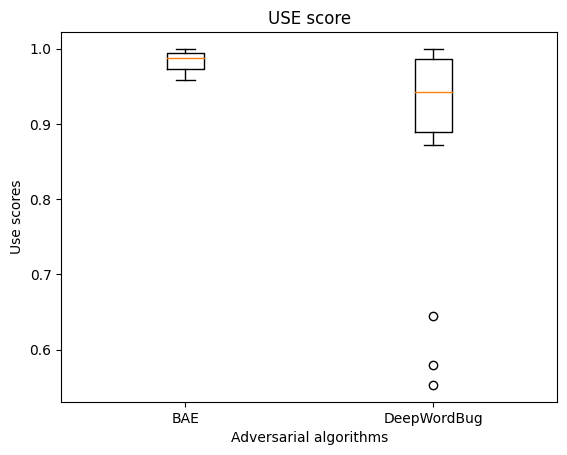

In [56]:
import matplotlib.pyplot as plt

# Create a figure and an axis
fig, ax = plt.subplots()

# Create the box plots
ax.boxplot(box_plots_data)

# Set the labels for the x-axis
ax.set_xticklabels(['BAE', 'DeepWordBug'])

# Add title and labels
ax.set_title('USE score')
ax.set_xlabel('Adversarial algorithms')
ax.set_ylabel('Use scores')

# Show the plot
plt.show()

## New attack